### **High Frequency Trading Strategies Design using ML and DL**

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 13 22:40:00 2022

@author: Bradley

HFT: Machine Learning Techniques on Full Orderbook Tick Data
"""

'\nCreated on Sun Mar 13 22:40:00 2022\n\n@author: Bradley\n\nHFT: Machine Learning Techniques on Full Orderbook Tick Data\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import csv

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (8,5) #提前设置图片形状大小

%config InlineBackend.figure_format = 'svg'

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
pd.set_option('expand_frame_repr', False)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180)

In [3]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

### **Model Fitting**

In [4]:
# load the features
def read_csv(day_trade):
    data_up = []
    data_down = []
    for j,i in enumerate(day_trade):
        for k in range(0,len(i),1):
            path_up = './processed_data/order_book_3_2014_new' + '_' + str(j+1) + '_' + str(i[k]) + '_' + 'UP' + '.csv'
            path_down = './processed_data/order_book_3_2014_new' + '_' + str(j+1) + '_' + str(i[k]) + '_' + 'DOWN' + '.csv'
            data_up.append(pd.read_csv(path_up))
            data_down.append(pd.read_csv(path_down))
    return data_up,data_down

In [5]:
# 读取数据
# 如果有更多的天数，只用改变日期参数即可
day_trade = [[2]]
data_2014_up, data_2014_down = read_csv(day_trade)

In [6]:
# 0列是要预测的label

# 查看上午的feature数据，第一列为0代表not trade，第一列为1代表trade，后面列都是feature value
data_2014_up[0].head(10)

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.553936,4.656716,0.646438,1.532051,0.210127,2.462585,0.422397,14.074595,7110.0,7100.0
1,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.553936,4.656716,0.646438,1.532051,0.210127,2.462585,0.422397,14.074595,7110.0,7100.0
2,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.497382,0.354839,-0.476190,2.396396,0.411141,1.803571,0.286624,14.044944,7125.0,7115.0
3,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.497382,0.354839,-0.476190,1.003774,0.001883,0.909910,-0.047170,14.044944,7125.0,7115.0
4,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.926773,0.040590,-0.921986,0.406107,-0.422367,0.268617,-0.576520,14.044944,7125.0,7115.0
5,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.926773,0.040590,-0.921986,0.416794,-0.411638,0.275266,-0.568300,14.044944,7125.0,7115.0
6,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.926773,0.040590,-0.921986,0.737405,-0.151142,0.474734,-0.356177,14.044944,7125.0,7115.0
7,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.922374,0.044280,-0.915194,0.738931,-0.150132,0.477394,-0.353735,14.044944,7125.0,7115.0
8,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.922374,0.044280,-0.915194,0.738931,-0.150132,0.477394,-0.353735,14.044944,7125.0,7115.0
9,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.912188,0.049815,-0.905097,0.741985,-0.148116,0.481383,-0.350090,14.044944,7125.0,7115.0


**Model Selection**

In [7]:
# 设置需要使用到的ML、DL模型，设置random_state使结果可复制
# 可以自行添加更多的分类器，例如MLP，xgboost，软投票分类器等等二分类工具

models = {
    'RandomForestClassifier': RandomForestClassifier(random_state = 0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state = 0),
    'AdaBoostClassifier': AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), n_estimators = 10,random_state = 0),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state = 0),
    'SVC': SVC(probability=True,random_state = 0),
}

In [8]:
# 设置hyperparameter tuning的网格搜索参数

model_grid_params = {
    'RandomForestClassifier': {'max_features':[None],'n_estimators':[10],'max_depth':[10],\
                               'min_samples_split':[2],'criterion':['entropy'],\
                               'min_samples_leaf':[3]},
    'ExtraTreesClassifier': {'max_features':[None],'n_estimators':[10],'max_depth':[10],\
                             'min_samples_split':[2],'criterion':['entropy'],\
                             'min_samples_leaf':[3]},
    'AdaBoostClassifier': {"base_estimator__criterion" : ["entropy"],\
                           "base_estimator__max_depth": [None],\
                           "base_estimator__min_samples_leaf" : [3],\
                           "base_estimator__min_samples_split" : [2],\
                           "base_estimator__max_features" : [None]},
    'GradientBoostingClassifier': {'max_features':[None],'n_estimators':[10],'max_depth':[10],\
                                   'min_samples_split':[2],'min_samples_leaf':[3],\
                                   'learning_rate':[0.1],'subsample':[1.0]},
    'SVC': [{'kernel':['rbf'],'gamma':[1e-1],'C':[1]},\
            {'kernel':['linear'],'C':[1, 10]}]
}

#### **Model Selection Pipline**

In [11]:
class Model_Selection:
    
    def __init__(self,models,model_grid_params,data_2014,latest_sec,pred_sec,day):
        self.models = models
        self.model_grid = model_grid_params
        self.data_2014 = data_2014
        self.latest_sec = latest_sec
        self.pred_sec = pred_sec
        self.day = day
        self.keys = models.keys()
        self.best_score = {}
        self.grid = {}
        self.predict_values = {}
        self.cv_acc = {}
        self.acc = {}
        self.fscore = {}
        self.true_values = {}
        self.predict_values_day = {}
        self.cv_acc_day = {}
        self.acc_day = {}
        self.fscore_day = {}
        self.true_values_day = {}
        self.summary_day = []
        
    def Grid_fit(self,X_train,y_train,cv = 5,scoring = 'accuracy'):
        
        for key in self.keys:
            print("Running GridSearchCV for %s." %(key))
            model = self.models[key]
            model_grid = self.model_grid[key]
            Grid = GridSearchCV(model, model_grid, cv = cv, scoring = scoring)
            Grid.fit(X_train,y_train) 
            self.grid[key] = Grid
            print(Grid.best_params_)
            print('CV Best Score = %s'%(Grid.best_score_))
            self.cv_acc[key].append(Grid.best_score_)  
    
    def model_fit(self,X_train, y_train, X_test, y_test):
        
        for key in self.keys:
            print("Running training & testing for %s." %(key))
            model = self.models[key]
            # print(self.grid[key].best_params_)
            model.set_params(**self.grid[key].best_params_)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            #print 'Prediction latest 15 second = %s'%(predictions)
            self.predict_values[key].append(predictions.tolist())
            self.true_values[key].append(y_test.tolist())
            acc = metrics.accuracy_score(y_test,predictions)
            f_score = metrics.f1_score(y_test,predictions)
            print('Accuracy = %s'%(acc))
            self.acc[key].append(acc)
            self.fscore[key].append(f_score)
            
            if key == 'SVC':
                if self.grid[key].best_params_['kernel'] == 'linear':
                    feature_imp = dict(zip([i for i in range(0,64,1)],model.coef_[0]))
                    Top_five = sorted(feature_imp.items(),key = lambda x : x[1] , reverse=True)[0:5]
                    print('Kernel is linear and top five importance features = %s'%(Top_five))
                else:
                    print('Kernel is rbf')
                    pass
            else: 
                feature_imp = dict(zip([i for i in range(0,64,1)],model.feature_importances_))
                Top_five = sorted(feature_imp.items(),key = lambda x : x[1] , reverse=True)[0:5]
                print('Top five importance features = %s'%(Top_five))
                pass

    def pipline(self):
        
        self.set_list_day() # store day values
        for day in range(0,self.day,1):
            self.set_list() # store values
            print('Day = %s'%(day+1))
            for i in range(0, 9000-self.latest_sec-600, self.pred_sec):
            # for i in range(0, 9000-self.latest_sec-600, self.pred_sec):
            # for i in range(0, 200, self.pred_sec):

                
                print('--------------------Rolling Window Time = %s--------------------'%(i/pred_sec))
                # Train data
                data_train = self.data_2014[day][i:i+self.latest_sec]
                # X_train = data_train.drop(['0'],axis=1)#,'65','66','67'],axis=1)
                X_train = data_train.drop(['0','65','66','67'],axis=1)
                y_train = data_train['0']

                # Test data
                data_test = self.data_2014[day][i + self.latest_sec:i + self.latest_sec + self.pred_sec]
                # X_test = data_test.drop(['0'],axis=1)#,'65','66','67'],axis=1)
                X_test = data_test.drop(['0','65','66','67'],axis=1)
                y_test = data_test['0']
                
                #start = time.time()
                self.Grid_fit(X_train, y_train, cv = 5, scoring = 'accuracy')
                self.model_fit(X_train, y_train,X_test,y_test)
                #end = time.time()
                #print 'Total Time = %s'%(end - start)
                
            for key in self.keys:
                
                self.cv_acc_day[key].append(self.cv_acc[key])
                self.acc_day[key].append(self.acc[key])
                self.fscore_day[key].append(self.fscore[key])
                self.true_values_day[key].append(self.true_values[key])
                self.predict_values_day[key].append(self.predict_values[key])
            
            self.summary_day.append(self.score_summary(sort_by = 'Accuracy_mean'))
    
    def set_list(self):
        
        for key in self.keys:
            self.predict_values[key] = []
            self.cv_acc[key] = []
            self.acc[key] = []
            self.fscore[key] = []
            self.true_values[key] = []
            
    def set_list_day(self):
        
        for key in self.keys:
            self.predict_values_day[key] = []
            self.cv_acc_day[key] = []
            self.acc_day[key] = []
            self.fscore_day[key] = []
            self.true_values_day[key] = []
            
    def score_summary(self,sort_by):
        
        summary = pd.concat([pd.DataFrame(self.acc.keys()),pd.DataFrame(map(lambda x: np.mean(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: np.std(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: np.max(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: np.min(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: np.mean(self.fscore[x]), self.fscore))],axis=1)
        summary.columns = ['Estimator','Accuracy_mean','Accuracy_std','Accuracy_max','Accuracy_min','F_score']
        summary.index.rename('Ranking', inplace=True)
        return summary.sort_values(by = [sort_by], ascending=False)
          
    def print_(self):
        print(self.predict_values)


In [12]:
# 试运行一组参数
# 此处训练集为30min滚动窗口，测试集为未来10s的label值
latest_sec = 60 * 30
pred_sec = 10
data_2014_up, data_2014_down = read_csv(day_trade)
day = 1
data_2014 = data_2014_up
# day=2
# data_2014 = data_2014_up + data_2014_down
pip = Model_Selection(models,model_grid_params,data_2014,latest_sec,pred_sec,day)

In [13]:
# 模型拟合
start = time.time()
pip.pipline()
end = time.time()
print('Total Time = %s'%(end-start))

Day = 1
--------------------Rolling Window Time = 0.0--------------------
Running GridSearchCV for RandomForestClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7227777777777777
Running GridSearchCV for ExtraTreesClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7405555555555556
Running GridSearchCV for AdaBoostClassifier.
{'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__min_samples_leaf': 3, 'base_estimator__min_samples_split': 2}
CV Best Score = 0.7338888888888888
Running GridSearchCV for GradientBoostingClassifier.
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10, 'subsample': 1.0}
CV Best Score = 0.7150000

#### **Performance Metrics**

In [66]:
pip.summary_day[0].reset_index(drop = True)

,Estimator,Accuracy_mean,Accuracy_std,Accuracy_max,Accuracy_min,F_score
0,ExtraTreesClassifier,0.934848,0.183231,1.0,0.0,0.693221
1,AdaBoostClassifier,0.926818,0.194295,1.0,0.0,0.696346
2,GradientBoostingClassifier,0.913636,0.223258,1.0,0.0,0.687364
3,RandomForestClassifier,0.912879,0.217564,1.0,0.0,0.689781
4,SVC,0.825455,0.325279,1.0,0.0,0.666460


In [ ]:
# pip.summary_day[1]#.reset_index(drop = True)

In [ ]:
# pip.summary_day[2]#.reset_index(drop = True)

**Best Bid and Best Ask**

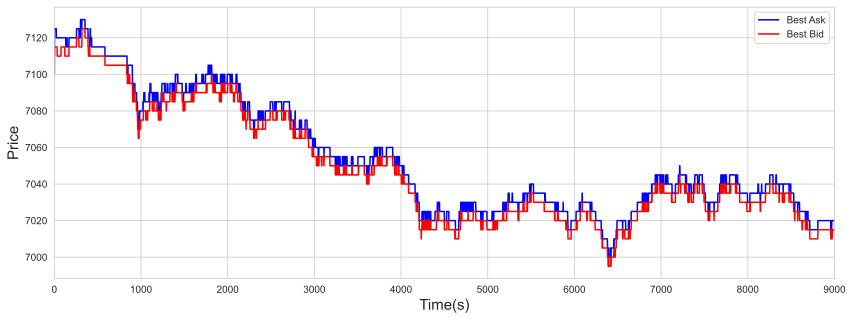

In [16]:
# first day
sns.set_style("whitegrid")
plt.figure(figsize = (14,5))
color_ = ['r','b']
plt.plot(data_2014[0]['66'],label = 'Best Ask',color = color_[1])
plt.plot(data_2014[0]['67'],label = 'Best Bid',color = color_[0])
plt.xlim(0, 9000)
plt.legend(loc=0)
plt.xlabel('Time(s)',size = 15)
plt.ylabel('Price',size = 15)

plt.savefig("./images/best_bid_ask.png", dpi=800)
plt.show()

**Single Day Accuracy**

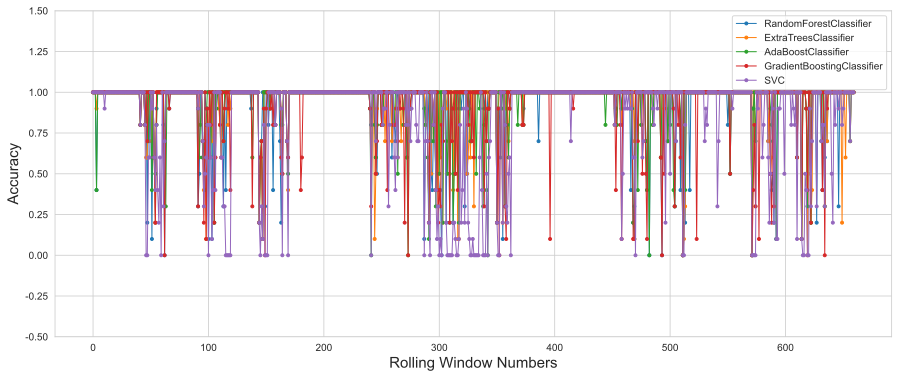

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize = (15,6))
color = []
for key in pip.keys:
    plt.plot(np.array(pip.acc_day[key])[0],'-o',label = key,lw = 1,markersize = 3)
    plt.legend(loc=0)
plt.ylim(-0.5,1.5)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('Accuracy',size = 15)

plt.savefig("./images/single_day_accuracy.png", dpi=800)
plt.show()

**Cross-Validation Results**

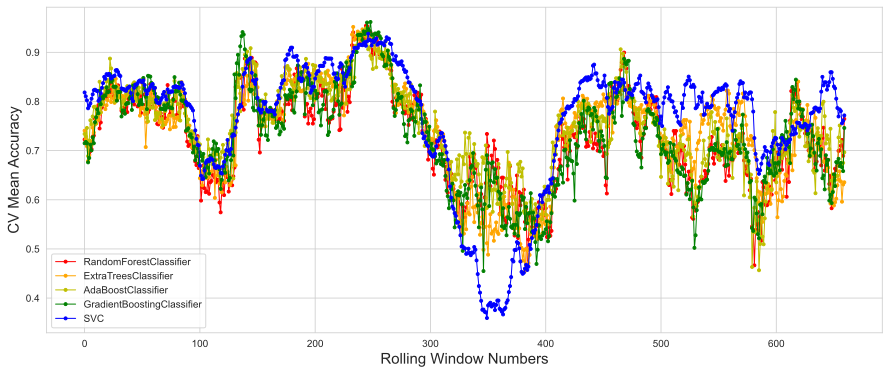

In [21]:
sns.set_style("whitegrid")
plt.figure(figsize = (15,6))
color_ = ['r','orange','y','g','b']
for index,key in enumerate(pip.keys):
    plt.plot(np.array(pip.cv_acc_day[key])[0],'-o',label = key,color = color_[index],lw = 1,markersize = 3)
#plot(best_cv_score,'-v',label = 'Best cv 5 folds score',color = 'violet',lw = 1,markersize = 6)
plt.legend(loc = 0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)
plt.savefig("./images/CV_result.png", dpi = 800)
plt.show()

**Obtain PnL and Best Cross-Validation Result**

In [46]:
# compute cum_profit and Best_cv_score
dict_ = {}
dict_['cum_profit'] = []
dict_['Best_cv_score'] = []

for day in range(0,1,1):
    cum_profit_label = []
    cum_profit = []
    best_cv_score = []
    hold_price = []
    true_label = []
    predict_label = []
    # spread = 0.2 * data_2014[day]['65'][1800:][9::10].values
    spread = data_2014[day]['65'][1800:][9::10].values
    # loss = 0.2*(data_2014[0]['67'][1800:9000-600][9::10].values - data_2014[day]['67'][1800+600:9000][9::10].values)
    # loss = data_2014[0]['67'][1800:9000-600][9::10].values - data_2014[day]['67'][1800+600:9000][9::10].values
    loss = -data_2014[day]['65'][1800:][9::10].values
    # for j in range(0,len(pip.cv_acc_day.values()[0][day]),1):
    for j in range(0,len(pip.cv_acc_day['RandomForestClassifier'][day]),1):
    
        max_al = {}
        for i in range(0,len(pip.keys),1):
            max_al[list(pip.keys)[i]] = np.array(pip.cv_acc_day[list(pip.keys)[i]])[day][j]
        # select best algorithm in cv = 5    
        top_cv_acc = sorted(max_al.items(),key = lambda x : x[1], reverse = True)[0:1][0]
        best_cv_score.append(top_cv_acc[1])
        submission = pip.predict_values_day[top_cv_acc[0]][day][j][-1]
        true_value = pip.true_values_day[top_cv_acc[0]][day][j][-1]
        true_label.append(true_value)
        predict_label.append(submission)
        hold_price.append(data_2014[0]['67'][1800:9000][9::10].values[j])

        if submission == true_value:
            if submission == 1:
                cum_profit_label.append(1)
                cum_profit.append(spread[j])
            elif submission == 0:
                cum_profit_label.append(0)
                cum_profit.append(0)
        elif submission != true_value:
            if submission == 1:
                cum_profit_label.append(-1)
                cum_profit.append(loss[j])
            elif submission == 0:
                cum_profit_label.append(0)
                cum_profit.append(0)
                
    dict_['cum_profit'].append(cum_profit)
    dict_['Best_cv_score'].append(best_cv_score)

**Best CV Score Visualization**

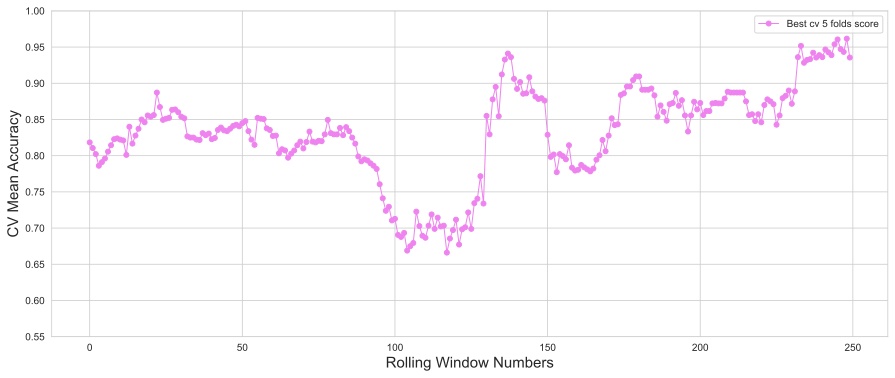

In [28]:
best_cv_score = dict_['Best_cv_score']

# 取一部分可视化
sns.set_style("whitegrid")
plt.figure(figsize = (15,6))
plt.plot(best_cv_score[0][0:250],'-o',label = 'Best cv 5 folds score',color = 'violet',lw = 1,markersize = 5)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)
plt.ylim(0.55,1)
plt.savefig("./images/best_CV_result.png", dpi=800)
plt.show()

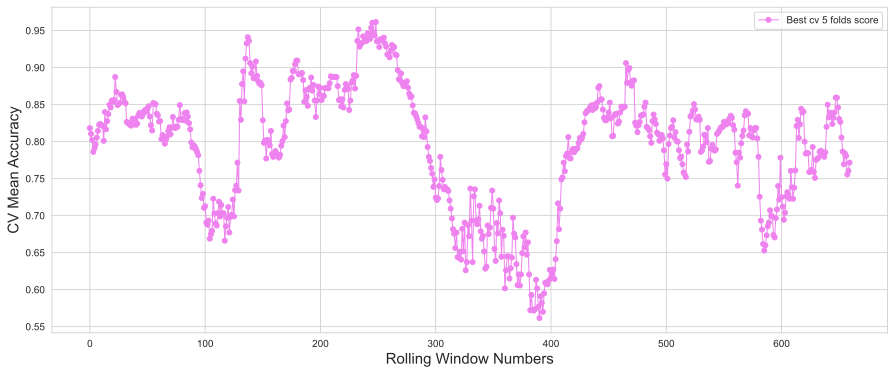

In [30]:
best_cv_score = dict_['Best_cv_score']

# 取全部rolling window可视化
sns.set_style("whitegrid")
plt.figure(figsize = (15,6))
plt.plot(best_cv_score[0],'-o',label = 'Best cv 5 folds score',color = 'violet',lw = 1,markersize = 5)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)
plt.savefig("./images/best_CV_result_all.png", dpi=800)
plt.show()

**PnL Visualization**

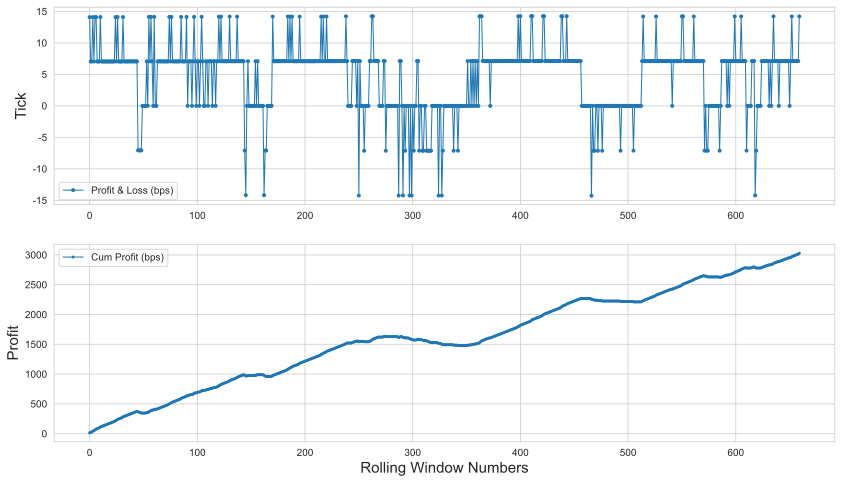

In [36]:
cum_profit = dict_['cum_profit']

sns.set_style("whitegrid")
plt.figure(figsize = (14,8))
plt.subplot(211)
plt.plot(cum_profit[0],'-o',label = 'Profit & Loss (bps)',lw = 1,markersize = 3)
plt.ylabel('Tick',size = 15)
plt.legend(loc=0)
# plt.ylim(-7.5,2.5)
plt.subplot(212)
plt.plot(np.cumsum(cum_profit[0]),'-o',label = 'Cum Profit (bps)',lw = 1,markersize = 2)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('Profit',size = 15)

plt.savefig("./images/best_CV_result_all.png", dpi=800)
plt.show()


In [44]:
# total profit in bps
cum_profit = dict_['cum_profit']
prof = [0] + cum_profit[0]
pd.DataFrame(np.cumsum(prof))

,0
0,0.000000
1,14.084507
2,21.129241
3,28.173975
4,42.268408
...,...
656,2992.858083
657,2999.962879
658,3007.067675
659,3014.172470


In [48]:
true_label[:10]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [49]:
predict_label[:10]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [51]:
hold_price[:10]

[7095.0,
 7095.0,
 7095.0,
 7090.0,
 7095.0,
 7090.0,
 7090.0,
 7090.0,
 7090.0,
 7090.0]

In [58]:
result = pd.DataFrame({"signal": predict_label, "close": hold_price})
result['pre_close'] = result['close'].shift()
result

,signal,close,pre_close
0,1.0,7095.0,NaN
1,1.0,7095.0,7095.0
2,1.0,7095.0,7095.0
3,1.0,7090.0,7095.0
4,1.0,7095.0,7090.0
...,...,...,...
655,1.0,7035.0,7035.0
656,1.0,7035.0,7035.0
657,1.0,7035.0,7035.0
658,1.0,7035.0,7035.0


In [62]:
# 由交易信号产生实际持仓
def position_at_close(df):
    """
    根据signal产生实际持仓。考虑涨跌停不能买入卖出的情况。
    所有的交易都是发生在产生信号的K线的结束时
    :param df:
    :return:
    """
    # ===由signal计算出实际的每天持有仓位
    # 在产生signal的k线结束的时候，进行买入
    df['signal'].fillna(method='ffill', inplace=True)
    df['signal'].fillna(value=0, inplace=True)  # 将初始行数的signal补全为0
    df['pos'] = df['signal'].shift()
    df['pos'].fillna(value=0, inplace=True)  # 将初始行数的pos补全为0

    return df

# 计算资金曲线
def equity_curve_with_long_at_close(df, c_rate=2.5/10000, t_rate=1.0/1000, slippage=0.01):
    """
    计算股票的资金曲线。只能做多，不能做空。并且只针对满仓操作
    每次交易是以当根K线的收盘价为准。
    :param df:
    :param c_rate: 手续费，commission fees，默认为万分之2.5
    :param t_rate: 印花税，tax，默认为千分之1。etf没有
    :param slippage: 滑点，股票默认为0.01元，etf为0.001元
    :return:
    """

    # ==找出开仓、平仓条件
    condition1 = df['pos'] != 0
    condition2 = df['pos'] != df['pos'].shift(1)
    open_pos_condition = condition1 & condition2

    condition1 = df['pos'] != 0
    condition2 = df['pos'] != df['pos'].shift(-1)
    close_pos_condition = condition1 & condition2


    # ===基本参数
    initial_cash = 10000  # 初始资金，默认为10000元

    # ===在买入的K线
    # 在发出信号的当根K线以收盘价买入
    df.loc[open_pos_condition, 'stock_num'] = initial_cash * (1 - c_rate) / (df['pre_close'] + slippage)

    # 买入股票之后剩余的钱，扣除了手续费
    df['cash'] = initial_cash - df['stock_num'] * (df['pre_close'] + slippage) * (1 + c_rate)

    # 收盘时的股票净值
    df['stock_value'] = df['stock_num'] * df['close']

    # ===在买入之后的K线
    # 买入之后现金不再发生变动
    df['cash'].fillna(method='ffill', inplace=True)
    df.loc[df['pos'] == 0, ['cash']] = None

    # ===在卖出的K线
    # 股票数量变动
    df.loc[close_pos_condition, 'stock_num'] = df['stock_value'] / df['close']  # 看2006年初

    # 现金变动
    df.loc[close_pos_condition, 'cash'] += df.loc[close_pos_condition, 'stock_num'] * (df['close'] - slippage) * (
                1 - c_rate - t_rate)
    # 股票价值变动
    df.loc[close_pos_condition, 'stock_value'] = 0

    # ===账户净值
    df['net_value'] = df['stock_value'] + df['cash']

    # ===计算资金曲线
    df['equity_change'] = df['net_value'].pct_change(fill_method=None)
    df.loc[open_pos_condition, 'equity_change'] = df.loc[open_pos_condition, 'net_value'] / initial_cash - 1  # 开仓日的收益率
    df['equity_change'].fillna(value=0, inplace=True)
    df['equity_curve'] = (1 + df['equity_change']).cumprod()
    df['equity_curve_base'] = (df['close'] / df['pre_close']).cumprod()

    # ===删除无关数据
    df.drop(['stock_num', 'cash', 'stock_value', 'net_value'], axis=1, inplace=True)

    return df

In [63]:
result1 = position_at_close(result)
df = equity_curve_with_long_at_close(result1, 0, 0, 0)
df

,signal,close,pre_close,pos,equity_change,equity_curve,equity_curve_base
0,1.0,7095.0,NaN,0.0,0.0,1.00000,NaN
1,1.0,7095.0,7095.0,1.0,0.0,1.00000,1.000000
2,1.0,7095.0,7095.0,1.0,0.0,1.00000,1.000000
3,1.0,7090.0,7095.0,1.0,0.0,1.00000,0.999295
4,1.0,7095.0,7090.0,1.0,0.0,1.00000,1.000000
...,...,...,...,...,...,...,...
655,1.0,7035.0,7035.0,1.0,0.0,1.00215,0.991543
656,1.0,7035.0,7035.0,1.0,0.0,1.00215,0.991543
657,1.0,7035.0,7035.0,1.0,0.0,1.00215,0.991543
658,1.0,7035.0,7035.0,1.0,0.0,1.00215,0.991543


In [64]:
# 如果需要具体的index，哪里发生了最大回撤，那两行，再加上一些robust处理
def max_drawdown(X):
    X = np.array(X)
    try:
        i = np.argmin((X - np.maximum.accumulate(X))/np.maximum.accumulate(X))
        j = np.argmax(X[:i])
        return i, j, (X[i]-X[j])/X[j]
    except:
        return 0
max_drawdown(df['equity_curve'])

(250, 109, -0.0028358848906817895)

In [65]:
# 计算累积收益, exp_rate为业绩报酬率
def cum_return(X: pd.Series, exp_rate=0):
    X = np.array(X)
    t = (X[-1]-X[0])/X[0]
    if t > 0:
        return t * (1-exp_rate)
    else:
        return t
cum_return(df['equity_curve'])

0.002149927061774415

**More: Develop the effect of training window period**

In [ ]:
pred_sec = 10
data_2014_up, data_2014_down = read_csv(day_trade)
day = 1
data_2014 = data_2014_up
# day=2
# data_2014 = data_2014_up+ data_2014_down

color_ = ['r','orange','y','g','b']

x = []
y = {'RandomForestClassifier': [],
 'ExtraTreesClassifier': [],
 'AdaBoostClassifier': [],
 'GradientBoostingClassifier': [],
 'SVC': []}

for latest_sec in range(10, 660,2):
    pip = Model_Selection(models,model_grid_params,data_2014,latest_sec,pred_sec,day)
    pip.pipline()
    x.append(latest_sec)
    for index,key in enumerate(pip.keys):
        y[key].append(pip.cv_acc_day[key][0])


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize = (15,6))
plt.ylim(0.6, 1)
plt.xlim(0, 700)
for index,key in enumerate(pip.keys):
    plt.plot(x, y[key],'-o',label = key ,color = color_[index], lw = 1, markersize = 2)
    # plot(best_cv_score,'-v',label = 'Best cv 5 folds score',color = 'violet',lw = 1,markersize = 6)
plt.legend(loc=0)
plt.xlabel('Training Sliding Window',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)